FEATURE ENGINEERING

EKSİK DEĞER ANALİZİ

In [1]:
# Gerekli Kütüphane ve Fonksiyonlar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
# from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter(action="ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
#pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
df = pd.read_csv("C:/Users/HP/Desktop/Diyabet tahmin projesi/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


Bir insanda Pregnancies ve Outcome dışındaki değişken değerleri 0 olamayacağı bilinmektedir.
Bundan dolayı bu değerlerle ilgili aksiyon kararı alınmalıdır. 0 olan değerlere NaN atanabilir.

In [3]:
df.isnull().sum() # eksik degerler yoktu. Fakat sıfır olamayacak değişkenlere sıfır atanmıstı.
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000
mean,3.845,120.895,69.105,20.536,79.799,31.993,0.472,33.241,0.349
std,3.370,31.973,19.356,15.952,115.244,7.884,0.331,11.760,0.477
min,0.000,0.000,0.000,0.000,0.000,0.000,0.078,21.000,0.000
25%,1.000,99.000,62.000,0.000,0.000,27.300,0.244,24.000,0.000
50%,3.000,117.000,72.000,23.000,30.500,32.000,0.372,29.000,0.000
75%,6.000,140.250,80.000,32.000,127.250,36.600,0.626,41.000,1.000
max,17.000,199.000,122.000,99.000,846.000,67.100,2.420,81.000,1.000


In [4]:
# minimum degeri sıfır olamayacak değişkenler yakalanıyor.
# kategorik değişkenler hariç bırakılıyor.
zero_columns = [col for col in df.columns if (df[col].min() == 0 and col not in ["Pregnancies", "Outcome"])]

zero_columns

# Gözlem birimlerinde 0 olan degiskenlerin her birisine gidip 0 iceren gozlem degerlerini NaN ile değiştirdik.

['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

In [5]:
# where ile eger ki şart saglanıyorsa NAN yazacagım, saglanmıyorsa oldugu gibi yazacagım.
for col in zero_columns:
    df[col] = np.where(df[col] == 0, np.nan, df[col])

In [6]:
# Eksik Gözlem Analizi
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [7]:
# artık eksik degerlerin oranını (NAN) incelebilirz.
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0] # eksik deger varsa na_columns değişkeninde tutulur.
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False) # sıralamanın sebebi ilk olarak fazla eksik degere sahip eğişkenleri görmek istememiz.
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False) # eksik degerlerin tüm değerler içerisindeki oranı
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio']) # kac deger var ve oranını birleştiriyoruz.
    print(missing_df, end="\n")
    if na_name: #na_name true ise degeri döndürür.
        return na_columns

na_columns = missing_values_table(df, na_name=True)

               n_miss  ratio
Insulin           374 48.700
SkinThickness     227 29.560
BloodPressure      35  4.560
BMI                11  1.430
Glucose             5  0.650


In [8]:
# Eksik Değerlerin Bağımlı Değişken ile İlişkisinin İncelenmesi
# amacımız eksik degerler ile var olan degerlerin karsılastırmasını yapmak olacak.

def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()
    for col in na_columns: # eksik degeri olan değişkenlerde geziyoruz.
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0) # temp_df[col].isnull() degeri true false olarak döndürür. true ise 1: false ise 0 yazar.
        # bu işlemin amacı eksik olan degerlerde var olan degerleri ayrıstırmaktır.
    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns # NA barındıran değişkenlerde gezmek istiyorum. yeni değişkene atadım.
    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")


missing_vs_target(df, "Outcome", na_columns)
# Eksikse 1 değilse 0.

                 TARGET_MEAN  Count
Glucose_NA_FLAG                    
0                      0.349    763
1                      0.400      5


                       TARGET_MEAN  Count
BloodPressure_NA_FLAG                    
0                            0.344    733
1                            0.457     35


                       TARGET_MEAN  Count
SkinThickness_NA_FLAG                    
0                            0.333    541
1                            0.388    227


                 TARGET_MEAN  Count
Insulin_NA_FLAG                    
0                      0.330    394
1                      0.369    374


             TARGET_MEAN  Count
BMI_NA_FLAG                    
0                  0.351    757
1                  0.182     11




In [9]:
# Eksik Değerlerin Doldurulması
for col in zero_columns:
    df.loc[df[col].isnull(), col] = df[col].median()


In [10]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [11]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000
mean,3.845,121.656,72.387,29.108,140.672,32.455,0.472,33.241,0.349
std,3.370,30.438,12.097,8.791,86.383,6.875,0.331,11.760,0.477
min,0.000,44.000,24.000,7.000,14.000,18.200,0.078,21.000,0.000
25%,1.000,99.750,64.000,25.000,121.500,27.500,0.244,24.000,0.000
50%,3.000,117.000,72.000,29.000,125.000,32.300,0.372,29.000,0.000
75%,6.000,140.250,80.000,32.000,127.250,36.600,0.626,41.000,1.000
max,17.000,199.000,122.000,99.000,846.000,67.100,2.420,81.000,1.000


AYKIRI DEĞER ANALİZİ

In [12]:
# aykırı degerler için limit belirleme
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [13]:
# aykırı deger var mı yok mu?
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [14]:
# aykırı degerleri baskılama
def replace_with_thresholds(dataframe, variable, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1=0.05, q3=0.95)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [15]:
# Aykırı Değer Analizi
for col in df.columns:
    print(col, check_outlier(df, col))
    if check_outlier(df, col):
        replace_with_thresholds(df, col)


Pregnancies False
Glucose False
BloodPressure False
SkinThickness True
Insulin True
BMI False
DiabetesPedigreeFunction False
Age False
Outcome False


SkinThickness ve Insulin değerlerinde aykırı değerler olduğunu görüyoruz.

<Axes: xlabel='Insulin'>

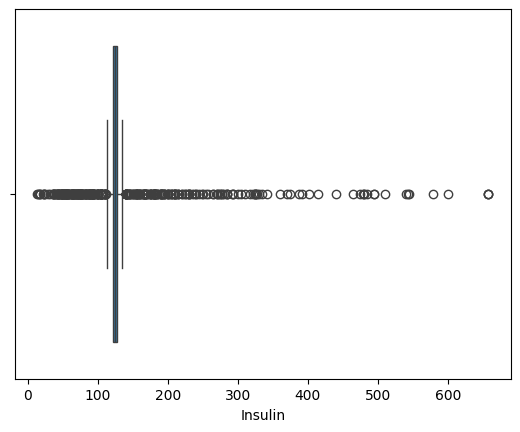

In [16]:
sns.boxplot(x=df["Insulin"])

<Axes: xlabel='SkinThickness'>

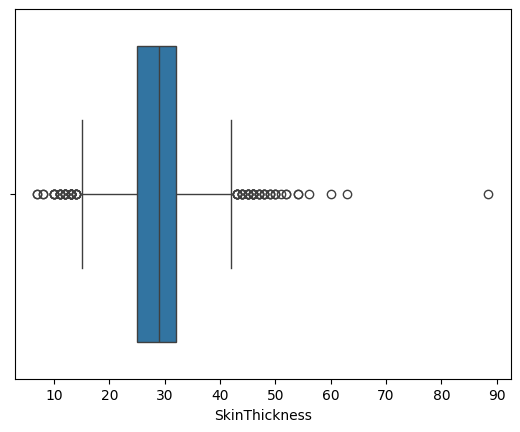

In [17]:
sns.boxplot(x=df["SkinThickness"])

In [18]:
#Aykırı Değer Baskılama İşlemi
for col in df.columns:
    print(col, check_outlier(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False
Outcome False


ÖZELLİK ÇIKARIMI

In [19]:
# Yaş değişkenini kategorilere ayırıp yeni yaş değişkeni oluşturulması
df.loc[(df["Age"] >= 21) & (df["Age"] < 50), "NEW_AGE_CAT"] = "mature"
df.loc[(df["Age"] >= 50), "NEW_AGE_CAT"] = "senior"

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NEW_AGE_CAT
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,senior
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,mature
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,mature
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,mature
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,mature


In [20]:
# BMI 18,5 aşağısı underweight, 18.5 ile 24.9 arası normal, 24.9 ile 29.9 arası Overweight ve 30 üstü obez
df['NEW_BMI'] = pd.cut(x=df['BMI'], bins=[0, 18.5, 24.9, 29.9, 100],labels=["Underweight", "Healthy", "Overweight", "Obese"])
#literatur taramasından elde ettigimiz degerler.

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NEW_AGE_CAT,NEW_BMI
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,senior,Obese
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,mature,Overweight
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,mature,Healthy
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,mature,Overweight
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,mature,Obese


In [21]:
# Glukoz degerini kategorik değişkene çevirme
df["NEW_GLUCOSE"] = pd.cut(x=df["Glucose"], bins=[0, 140, 200, 300], labels=["Normal", "Prediabetes", "Diabetes"])

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NEW_AGE_CAT,NEW_BMI,NEW_GLUCOSE
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,senior,Obese,Prediabetes
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,mature,Overweight,Normal
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,mature,Healthy,Prediabetes
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,mature,Overweight,Normal
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,mature,Obese,Normal


In [22]:
# Yaş ve beden kitle indeksini bir arada düşünerek kategorik değişken oluşturma 3 kırılım yakalandı
df.loc[(df["BMI"] < 18.5) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "underweightmature"
df.loc[(df["BMI"] < 18.5) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "underweightsenior"
df.loc[((df["BMI"] >= 18.5) & (df["BMI"] < 25)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "healthymature"
df.loc[((df["BMI"] >= 18.5) & (df["BMI"] < 25)) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "healthysenior"
df.loc[((df["BMI"] >= 25) & (df["BMI"] < 30)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "overweightmature"
df.loc[((df["BMI"] >= 25) & (df["BMI"] < 30)) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "overweightsenior"
df.loc[(df["BMI"] > 18.5) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "obesemature"
df.loc[(df["BMI"] > 18.5) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "obesesenior"

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NEW_AGE_CAT,NEW_BMI,NEW_GLUCOSE,NEW_AGE_BMI_NOM
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,senior,Obese,Prediabetes,obesesenior
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,mature,Overweight,Normal,obesemature
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,mature,Healthy,Prediabetes,obesemature
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,mature,Overweight,Normal,obesemature
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,mature,Obese,Normal,obesemature


In [23]:
# Yaş ve Glikoz değerlerini bir arada düşünerek kategorik değişken oluşturma
df.loc[(df["Glucose"] < 70) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "lowmature"
df.loc[(df["Glucose"] < 70) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "lowsenior"
df.loc[((df["Glucose"] >= 70) & (df["Glucose"] < 100)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "normalmature"
df.loc[((df["Glucose"] >= 70) & (df["Glucose"] < 100)) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "normalsenior"
df.loc[((df["Glucose"] >= 100) & (df["Glucose"] <= 125)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "hiddenmature"
df.loc[((df["Glucose"] >= 100) & (df["Glucose"] <= 125)) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "hiddensenior"
df.loc[(df["Glucose"] > 125) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "highmature"
df.loc[(df["Glucose"] > 125) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "highsenior"

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NEW_AGE_CAT,NEW_BMI,NEW_GLUCOSE,NEW_AGE_BMI_NOM,NEW_AGE_GLUCOSE_NOM
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,senior,Obese,Prediabetes,obesesenior,highsenior
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,mature,Overweight,Normal,obesemature,normalmature
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,mature,Healthy,Prediabetes,obesemature,highmature
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,mature,Overweight,Normal,obesemature,normalmature
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,mature,Obese,Normal,obesemature,highmature


In [24]:
# İnsulin Değeri ile Kategorik değişken türetmek
def set_insulin(dataframe, col_name="Insulin"):
    if 16 <= dataframe[col_name] <= 166:
        return "Normal"
    else:
        return "Abnormal"

In [25]:
df["NEW_INSULIN_SCORE"] = df.apply(set_insulin, axis=1)

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NEW_AGE_CAT,NEW_BMI,NEW_GLUCOSE,NEW_AGE_BMI_NOM,NEW_AGE_GLUCOSE_NOM,NEW_INSULIN_SCORE
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,senior,Obese,Prediabetes,obesesenior,highsenior,Normal
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,mature,Overweight,Normal,obesemature,normalmature,Normal
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,mature,Healthy,Prediabetes,obesemature,highmature,Normal
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,mature,Overweight,Normal,obesemature,normalmature,Normal
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,mature,Obese,Normal,obesemature,highmature,Abnormal


In [26]:
df["NEW_GLUCOSE*INSULIN"] = df["Glucose"] * df["Insulin"]

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NEW_AGE_CAT,NEW_BMI,NEW_GLUCOSE,NEW_AGE_BMI_NOM,NEW_AGE_GLUCOSE_NOM,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,senior,Obese,Prediabetes,obesesenior,highsenior,Normal,18500.000
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,mature,Overweight,Normal,obesemature,normalmature,Normal,10625.000
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,mature,Healthy,Prediabetes,obesemature,highmature,Normal,22875.000
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,mature,Overweight,Normal,obesemature,normalmature,Normal,8366.000
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,mature,Obese,Normal,obesemature,highmature,Abnormal,23016.000


In [27]:
# Sıfır olan değerler dikkat etmemiz gerekiyor.
df["NEW_GLUCOSE*PREGNANCIES"] = df["Glucose"] * df["Pregnancies"]
#df["NEW_GLUCOSE*PREGNANCIES"] = df["Glucose"] * (1+ df["Pregnancies"])

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NEW_AGE_CAT,NEW_BMI,NEW_GLUCOSE,NEW_AGE_BMI_NOM,NEW_AGE_GLUCOSE_NOM,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,senior,Obese,Prediabetes,obesesenior,highsenior,Normal,18500.000,888.000
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,mature,Overweight,Normal,obesemature,normalmature,Normal,10625.000,85.000
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,mature,Healthy,Prediabetes,obesemature,highmature,Normal,22875.000,1464.000
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,mature,Overweight,Normal,obesemature,normalmature,Normal,8366.000,89.000
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,mature,Obese,Normal,obesemature,highmature,Abnormal,23016.000,0.000


In [28]:
# Kolonların isimlerinin farklı olmaması için büyültülmesi.
df.columns = [col.upper() for col in df.columns]

df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_BMI,NEW_GLUCOSE,NEW_AGE_BMI_NOM,NEW_AGE_GLUCOSE_NOM,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,senior,Obese,Prediabetes,obesesenior,highsenior,Normal,18500.000,888.000
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,mature,Overweight,Normal,obesemature,normalmature,Normal,10625.000,85.000
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,mature,Healthy,Prediabetes,obesemature,highmature,Normal,22875.000,1464.000
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,mature,Overweight,Normal,obesemature,normalmature,Normal,8366.000,89.000
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,mature,Obese,Normal,obesemature,highmature,Abnormal,23016.000,0.000


ENCODING

In [29]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"] 
    #Veri tipinin object (O) olduğu sütunlar, tipik olarak kategorik sütunlardır. cat_cols listesine eklenir.

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"] # 0,1,2
    #Bu kısımda, sayısal görünümlü fakat benzersiz (unique) değer sayısı cat_th sınırından az olan sütunlar bulunur. 
    #Bu sütunlar sayısal olsa da, aslında kategorik gibi davranır. Bu sütunlar num_but_cat listesine eklenir.

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"] # name
    #Benzersiz değer sayısı car_th (örneğin 20) sınırını aşan ve veri tipi object olan sütunlar, kategorik olarak kabul edilir 
    #ancak çok fazla benzersiz değere sahip oldukları için "cardinality" problemi yaratabilirler.Bu sütunlar cat_but_car listesine eklenir.

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car] # cat_cols tüm object  veri tipini tuttugu için içerisinde cat_but_car bulunabilir.
    #İlk olarak, kategorik sütunlar (cat_cols) ve sayısal görünümlü kategorik sütunlar (num_but_cat) birleştirilir.
    #Ardından, "categorical but cardinal" sütunlar (cat_but_car), cat_cols listesinden çıkartılır. 
    #Bu, çok sayıda benzersiz değere sahip olan kategorik sütunların ayrı bir kategoriye alınmasını sağlar.

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat] #numerik_gorunumlu kategorikler hariç
    #Veri tipi object olmayan, yani sayısal olan sütunlar num_cols listesine eklenir.Ancak, sayısal görünümlü 
    #fakat aslında kategorik gibi davranan sütunlar (num_but_cat), bu listeden çıkartılır.

    print(f"Observations: {dataframe.shape[0]}") # satır
    print(f"Variables: {dataframe.shape[1]}") # sutun
    print(f'cat_cols: {len(cat_cols)}') # categorik degişken sayısı
    print(f'num_cols: {len(num_cols)}') # numerik değişkenler
    print(f'cat_but_car: {len(cat_but_car)}') # categorik fakat kardinal
    print(f'num_but_cat: {len(num_but_cat)}') # numerik görünümlü kategorik

    return cat_cols, num_cols, cat_but_car


In [30]:
#num_cols

In [31]:
#cat_cols

In [32]:
#cat_but_car

In [33]:
# Değişkenlerin tiplerine göre ayrılması işlemi
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 17
cat_cols: 7
num_cols: 10
cat_but_car: 0
num_but_cat: 3


LABEL ENCODING

In [34]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [35]:
binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]
print(binary_cols)

['NEW_AGE_CAT', 'NEW_INSULIN_SCORE']


In [36]:
for col in binary_cols:
    df = label_encoder(df, col)

df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_BMI,NEW_GLUCOSE,NEW_AGE_BMI_NOM,NEW_AGE_GLUCOSE_NOM,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,1,Obese,Prediabetes,obesesenior,highsenior,1,18500.000,888.000
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,0,Overweight,Normal,obesemature,normalmature,1,10625.000,85.000
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,0,Healthy,Prediabetes,obesemature,highmature,1,22875.000,1464.000
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,0,Overweight,Normal,obesemature,normalmature,1,8366.000,89.000
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,0,Obese,Normal,obesemature,highmature,0,23016.000,0.000


One-Hot Encoding İşlemi

In [37]:
# cat_cols listesinin güncelleme işlemi
cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["OUTCOME"]]
cat_cols

['NEW_AGE_BMI_NOM', 'NEW_AGE_GLUCOSE_NOM', 'NEW_BMI', 'NEW_GLUCOSE']

In [38]:
# target değişkenimi cıkarıyorum
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [39]:
# bir de binary_cols, zaten daha öncesinde label encoder uygulamıstım.
df = one_hot_encoder(df, cat_cols, drop_first=True)
#Birbiri üzerinden oluşturmayı önlemek için drop_first = True giriyoruz. İlk kolunu düşürmezsek modelde yanlılığa sebep olabilir.

In [40]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES,NEW_AGE_BMI_NOM_obesesenior,NEW_AGE_BMI_NOM_underweightmature,NEW_AGE_GLUCOSE_NOM_hiddensenior,NEW_AGE_GLUCOSE_NOM_highmature,NEW_AGE_GLUCOSE_NOM_highsenior,NEW_AGE_GLUCOSE_NOM_lowmature,NEW_AGE_GLUCOSE_NOM_lowsenior,NEW_AGE_GLUCOSE_NOM_normalmature,NEW_AGE_GLUCOSE_NOM_normalsenior,NEW_BMI_Healthy,NEW_BMI_Overweight,NEW_BMI_Obese,NEW_GLUCOSE_Prediabetes,NEW_GLUCOSE_Diabetes
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,1,1,18500.000,888.000,True,False,False,False,True,False,False,False,False,False,False,True,True,False
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,0,1,10625.000,85.000,False,False,False,False,False,False,False,True,False,False,True,False,False,False
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,0,1,22875.000,1464.000,False,False,False,True,False,False,False,False,False,True,False,False,True,False
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,0,1,8366.000,89.000,False,False,False,False,False,False,False,True,False,False,True,False,False,False
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,0,0,23016.000,0.000,False,False,False,True,False,False,False,False,False,False,False,True,False,False


# STANDARTLAŞTIRMA

In [41]:
num_cols

['PREGNANCIES',
 'GLUCOSE',
 'BLOODPRESSURE',
 'SKINTHICKNESS',
 'INSULIN',
 'BMI',
 'DIABETESPEDIGREEFUNCTION',
 'AGE',
 'NEW_GLUCOSE*INSULIN',
 'NEW_GLUCOSE*PREGNANCIES']

In [42]:
scaler = StandardScaler() # ortalaması sıfır, standart sapması bir olacak sekilde standardize ediyor.
df[num_cols] = scaler.fit_transform(df[num_cols])

df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES,NEW_AGE_BMI_NOM_obesesenior,NEW_AGE_BMI_NOM_underweightmature,NEW_AGE_GLUCOSE_NOM_hiddensenior,NEW_AGE_GLUCOSE_NOM_highmature,NEW_AGE_GLUCOSE_NOM_highsenior,NEW_AGE_GLUCOSE_NOM_lowmature,NEW_AGE_GLUCOSE_NOM_lowsenior,NEW_AGE_GLUCOSE_NOM_normalmature,NEW_AGE_GLUCOSE_NOM_normalsenior,NEW_BMI_Healthy,NEW_BMI_Overweight,NEW_BMI_Obese,NEW_GLUCOSE_Prediabetes,NEW_GLUCOSE_Diabetes
0,0.640,0.866,-0.032,0.680,-0.183,0.167,0.468,1.426,1,1,1,0.024,0.882,True,False,False,False,True,False,False,False,False,False,False,True,True,False
1,-0.845,-1.205,-0.528,-0.011,-0.183,-0.852,-0.365,-0.191,0,0,1,-0.503,-0.858,False,False,False,False,False,False,False,True,False,False,True,False,False,False
2,1.234,2.017,-0.694,-0.011,-0.183,-1.333,0.604,-0.106,1,0,1,0.317,2.129,False,False,False,True,False,False,False,False,False,True,False,False,True,False
3,-0.845,-1.074,-0.528,-0.702,-0.553,-0.634,-0.921,-1.042,0,0,1,-0.654,-0.849,False,False,False,False,False,False,False,True,False,False,True,False,False,False
4,-1.142,0.504,-2.679,0.680,0.331,1.549,5.485,-0.020,1,0,0,0.326,-1.042,False,False,False,True,False,False,False,False,False,False,False,True,False,False


In [43]:
df.shape

(768, 27)

In [44]:
df.head

<bound method NDFrame.head of      PREGNANCIES  GLUCOSE  BLOODPRESSURE  SKINTHICKNESS  INSULIN    BMI  \
0          0.640    0.866         -0.032          0.680   -0.183  0.167   
1         -0.845   -1.205         -0.528         -0.011   -0.183 -0.852   
2          1.234    2.017         -0.694         -0.011   -0.183 -1.333   
3         -0.845   -1.074         -0.528         -0.702   -0.553 -0.634   
4         -1.142    0.504         -2.679          0.680    0.331  1.549   
..           ...      ...            ...            ...      ...    ...   
763        1.828   -0.679          0.299          2.177    0.475  0.065   
764       -0.548    0.011         -0.197         -0.241   -0.183  0.632   
765        0.343   -0.022         -0.032         -0.702   -0.338 -0.910   
766       -0.845    0.143         -1.025         -0.011   -0.183 -0.343   
767       -0.845   -0.942         -0.197          0.219   -0.183 -0.299   

     DIABETESPEDIGREEFUNCTION    AGE  OUTCOME  NEW_AGE_CAT  NEW_INSUL

# MODELLEME

Feature Engineering ardından model basarısını degerlendirelim.

In [45]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES,NEW_AGE_BMI_NOM_obesesenior,NEW_AGE_BMI_NOM_underweightmature,NEW_AGE_GLUCOSE_NOM_hiddensenior,NEW_AGE_GLUCOSE_NOM_highmature,NEW_AGE_GLUCOSE_NOM_highsenior,NEW_AGE_GLUCOSE_NOM_lowmature,NEW_AGE_GLUCOSE_NOM_lowsenior,NEW_AGE_GLUCOSE_NOM_normalmature,NEW_AGE_GLUCOSE_NOM_normalsenior,NEW_BMI_Healthy,NEW_BMI_Overweight,NEW_BMI_Obese,NEW_GLUCOSE_Prediabetes,NEW_GLUCOSE_Diabetes
0,0.640,0.866,-0.032,0.680,-0.183,0.167,0.468,1.426,1,1,1,0.024,0.882,True,False,False,False,True,False,False,False,False,False,False,True,True,False
1,-0.845,-1.205,-0.528,-0.011,-0.183,-0.852,-0.365,-0.191,0,0,1,-0.503,-0.858,False,False,False,False,False,False,False,True,False,False,True,False,False,False
2,1.234,2.017,-0.694,-0.011,-0.183,-1.333,0.604,-0.106,1,0,1,0.317,2.129,False,False,False,True,False,False,False,False,False,True,False,False,True,False
3,-0.845,-1.074,-0.528,-0.702,-0.553,-0.634,-0.921,-1.042,0,0,1,-0.654,-0.849,False,False,False,False,False,False,False,True,False,False,True,False,False,False
4,-1.142,0.504,-2.679,0.680,0.331,1.549,5.485,-0.020,1,0,0,0.326,-1.042,False,False,False,True,False,False,False,False,False,False,False,True,False,False


In [46]:
df.columns

Index(['PREGNANCIES', 'GLUCOSE', 'BLOODPRESSURE', 'SKINTHICKNESS', 'INSULIN',
       'BMI', 'DIABETESPEDIGREEFUNCTION', 'AGE', 'OUTCOME', 'NEW_AGE_CAT',
       'NEW_INSULIN_SCORE', 'NEW_GLUCOSE*INSULIN', 'NEW_GLUCOSE*PREGNANCIES',
       'NEW_AGE_BMI_NOM_obesesenior', 'NEW_AGE_BMI_NOM_underweightmature',
       'NEW_AGE_GLUCOSE_NOM_hiddensenior', 'NEW_AGE_GLUCOSE_NOM_highmature',
       'NEW_AGE_GLUCOSE_NOM_highsenior', 'NEW_AGE_GLUCOSE_NOM_lowmature',
       'NEW_AGE_GLUCOSE_NOM_lowsenior', 'NEW_AGE_GLUCOSE_NOM_normalmature',
       'NEW_AGE_GLUCOSE_NOM_normalsenior', 'NEW_BMI_Healthy',
       'NEW_BMI_Overweight', 'NEW_BMI_Obese', 'NEW_GLUCOSE_Prediabetes',
       'NEW_GLUCOSE_Diabetes'],
      dtype='object')

In [47]:
y = df["OUTCOME"]
X = df.drop("OUTCOME", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

In [48]:
rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [49]:
print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test),3)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")

Accuracy: 0.79
Recall: 0.711
Precision: 0.67
F1: 0.69
Auc: 0.77


In [50]:
# Accuracy: 0.79
# Recall: 0.711
# Precision: 0.67
# F1: 0.69
# Auc: 0.77

# Base Model
# Accuracy: 0.77
# Recall: 0.706
# Precision: 0.59
# F1: 0.64
# Auc: 0.75